# How many lives did COVID-19 vaccines save in May/June 2021? 

The following is a code notebook which accompanies a research paper on this topic from MAXCOR labs. We will examine several topics:

[Actual Cases and Deaths](#section_id_1)

[Predicted Cases and Deaths](#section_id_2)

[Geography and culture questions](#section_id_3)

[Understanding R](#section_id_4)

In [1]:
# import libraries
import makedalytics as ma
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import rc
from datetime import datetime
from datetime import date
from pandas.tseries.offsets import DateOffset
# math libraries and packages
import math as mth
#import scipy
from scipy import stats
#fancy visualization and other fancy libraries and packages
import datetime as dt
from IPython.display import Markdown, display
##import plotly.express as px

<a id='section_id_1'></a>
## How many actual cases and deaths were there?
First we will read in and explore data from the Israeli Ministry of Health.

In [2]:

lancet_age_split= pd.read_csv('D:/MAXCORlabwork/covid/most_current_csvs/corona_age_and_gender_ver_00117.csv')

In [3]:
lancet_age_split

,first_week_day,last_week_day,age_group,gender,weekly_tests_num,weekly_cases,weekly_deceased
0,3/15/2020,3/21/2020,0-19,???,1028,32,0
1,3/15/2020,3/21/2020,0-19,?? ????,<15,0,0
2,3/15/2020,3/21/2020,0-19,????,838,34,0
3,3/15/2020,3/21/2020,20-24,???,666,99,0
4,3/15/2020,3/21/2020,20-24,?? ????,<15,0,0
...,...,...,...,...,...,...,...
3003,6/27/2021,7/3/2021,80+,?? ????,134,0,0
3004,6/27/2021,7/3/2021,80+,????,8920,<15,0
3005,6/27/2021,7/3/2021,NaN,???,3477,<15,0
3006,6/27/2021,7/3/2021,NaN,?? ????,6296,<15,0


In [4]:
lancet_age_split.age_group.unique()

array(['0-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+', nan],
      dtype=object)

In [5]:
print("some lines have no age recorded. out of 2008 rows we have ")
print(len(lancet_age_split[lancet_age_split.age_group.isna()]))
print("without age recorded , or")
print((len(lancet_age_split[lancet_age_split.age_group.isna()])/len(lancet_age_split))*100, "percent")


some lines have no age recorded. out of 2008 rows we have 
204
without age recorded , or
6.781914893617021 percent


## We see that we not only have data on cases and deaths on a weekly basis, but over 90% of the data (about 93.2%) has recorded ages
Next we will clean up the data a bit. We can not work with strings like <15. We will turn our numerical data numerical, and use 7 to replace <15. 

In [6]:
lancet_age_split.tail(4) 

,first_week_day,last_week_day,age_group,gender,weekly_tests_num,weekly_cases,weekly_deceased
3004,6/27/2021,7/3/2021,80+,????,8920,<15,0
3005,6/27/2021,7/3/2021,NaN,???,3477,<15,0
3006,6/27/2021,7/3/2021,NaN,?? ????,6296,<15,0
3007,6/27/2021,7/3/2021,NaN,????,5071,<15,0


In [7]:
lancet_age_split = lancet_age_split.drop(['last_week_day', 'gender'], axis = 1  )

In [8]:
lancet_age_split['weekly_cases'] = lancet_age_split['weekly_cases'].str.replace('<15', '7')
lancet_age_split['weekly_tests_num'] = lancet_age_split['weekly_tests_num'].str.replace('<15', '7')
lancet_age_split['weekly_deceased'] = lancet_age_split['weekly_deceased'].str.replace('<15', '7')


In [9]:
lancet_age_split['weekly_cases'] = pd.to_numeric(lancet_age_split['weekly_cases'])
lancet_age_split['weekly_tests_num'] = pd.to_numeric(lancet_age_split['weekly_tests_num'])
lancet_age_split['weekly_deceased'] = pd.to_numeric(lancet_age_split['weekly_deceased'])
 

In [10]:
over_70_people = ['70-74','75-79', '80+']
over_50_people = ['50-54', '55-59', '60-64', '65-69', '70-74','75-79', '80+']
#print(type(lancet_age_split.weekly_deceased[4]))

In [11]:
lancet_age_split['date'] = pd.to_datetime(lancet_age_split['first_week_day'], format= '%m/%d/%Y')
lancet_age_split
#gb['date_as_date'] = pd.to_datetime(gb['VaccinationDate'], format= '%Y-%m-%d')

,first_week_day,age_group,weekly_tests_num,weekly_cases,weekly_deceased,date
0,3/15/2020,0-19,1028,32,0,2020-03-15
1,3/15/2020,0-19,7,0,0,2020-03-15
2,3/15/2020,0-19,838,34,0,2020-03-15
3,3/15/2020,20-24,666,99,0,2020-03-15
4,3/15/2020,20-24,7,0,0,2020-03-15
...,...,...,...,...,...,...
3003,6/27/2021,80+,134,0,0,2021-06-27
3004,6/27/2021,80+,8920,7,0,2021-06-27
3005,6/27/2021,NaN,3477,7,0,2021-06-27
3006,6/27/2021,NaN,6296,7,0,2021-06-27


## Next we will make datasets by age group.

In [12]:
seventy_plus_age_split = lancet_age_split[lancet_age_split.age_group.isin(over_70_people)]
fifty_plus_age_split = lancet_age_split[lancet_age_split.age_group.isin(over_50_people)]

In [13]:
seventy_plus_age_split_sum = seventy_plus_age_split.groupby('date').sum()
fifty_plus_age_split_sum = fifty_plus_age_split.groupby('date').sum()
seventy_plus_age_split_sum

,weekly_tests_num,weekly_cases,weekly_deceased
date,,,
2020-03-15,1013,70,7
2020-03-22,2575,252,35
2020-03-29,4096,443,35
2020-04-05,4907,287,60
2020-04-12,12695,244,72
...,...,...,...
2021-05-30,10922,28,0
2021-06-06,9149,21,0
2021-06-13,11629,21,0


In [14]:
seventy_plus_age_split_sum = seventy_plus_age_split_sum.reset_index()
may_and_june_70plus = seventy_plus_age_split_sum[seventy_plus_age_split_sum.date > '2021-04-30']

In [15]:
may_and_june_70plus['cum_sum_may_june_deaths'] = may_and_june_70plus['weekly_deceased'].cumsum()

D:\bin\anaconda3\envs\jupyter_environment\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Let's take a peak at cumulative deaths in May and June for over 70s 

In [16]:
may_and_june_70plus

,date,weekly_tests_num,weekly_cases,weekly_deceased,cum_sum_may_june_deaths
59,2021-05-02,11884,35,28,28
60,2021-05-09,8856,42,14,42
61,2021-05-16,8528,42,14,56
62,2021-05-23,12472,35,14,70
63,2021-05-30,10922,28,0,70
64,2021-06-06,9149,21,0,70
65,2021-06-13,11629,21,0,70
66,2021-06-20,17854,51,0,70
67,2021-06-27,31354,110,0,70


In [17]:
fifty_plus_age_split_sum = fifty_plus_age_split_sum.reset_index()
fifty_plus_age_split_sum[fifty_plus_age_split_sum.date > '2021-04-30']

,date,weekly_tests_num,weekly_cases,weekly_deceased
59,2021-05-02,48564,105,49
60,2021-05-09,39477,91,35
61,2021-05-16,37046,91,21
62,2021-05-23,46231,98,35
63,2021-05-30,41485,70,14
64,2021-06-06,38245,70,0
65,2021-06-13,49863,77,0
66,2021-06-20,82376,207,7
67,2021-06-27,110505,411,0


<a id='section_id_2'></a>
## How many would have been predicted by vaccine efficacy?

In [18]:
vaccination = pd.read_csv('D:/MAXCORlabwork/covid/most_current_csvs/vaccinated_per_day_2021_07_03.csv')
vaccination['date_as_date'] = pd.to_datetime(vaccination['VaccinationDate'], format= '%Y-%m-%d')
vaccination.head(5)

,VaccinationDate,age_group,first_dose,second_dose,date_as_date
0,2020-12-20,20-29,392,0,2020-12-20
1,2020-12-20,80-89,93,0,2020-12-20
2,2020-12-20,0-19,21,0,2020-12-20
3,2020-12-20,60-69,1516,0,2020-12-20
4,2020-12-20,50-59,1785,0,2020-12-20


In [19]:
vaccination['second_dose'] = vaccination['second_dose'].str.replace('<15', '0')
vaccination['first_dose'] = vaccination['first_dose'].str.replace('<15', '0')
vaccination['first_dose'] = pd.to_numeric(vaccination['first_dose'])
vaccination['second_dose'] = pd.to_numeric(vaccination['second_dose'])

In [20]:
age_grouped_to19_vax = vaccination[vaccination.age_group == '0-19'].copy(deep = True)
age_grouped_to29_vax = vaccination[vaccination.age_group == '20-29'].copy(deep = True)
age_grouped_to39_vax = vaccination[vaccination.age_group == '30-39'].copy(deep = True)
age_grouped_to49_vax = vaccination[vaccination.age_group == '40-49'].copy(deep = True)
age_grouped_to59_vax = vaccination[vaccination.age_group == '50-59'].copy(deep = True)
age_grouped_to69_vax = vaccination[vaccination.age_group == '60-69'].copy(deep = True)
age_grouped_to79_vax = vaccination[vaccination.age_group == '70-79'].copy(deep = True)
age_grouped_to89_vax = vaccination[vaccination.age_group == '80-89'].copy(deep = True)
age_grouped_90plus_vax = vaccination[vaccination.age_group == '90+'].copy(deep = True)

In [21]:
age_grouped_to19_vax = age_grouped_to19_vax.rename(
    columns = {'first_dose':'first_dose_in_0to19',
                'second_dose': 'second_dose_in_0to19'}
    )
age_grouped_to29_vax = age_grouped_to29_vax.rename(
    columns = {'first_dose':'first_dose_in_20to29',
                'second_dose': 'second_dose_in_20to29'}
    )
age_grouped_to39_vax = age_grouped_to39_vax.rename(
    columns = {'first_dose':'first_dose_in_30to39',
                'second_dose': 'second_dose_in_30to39'}
    )
age_grouped_to49_vax = age_grouped_to49_vax.rename(
    columns = {'first_dose':'first_dose_in_40to49',
                'second_dose': 'second_dose_in_40to49'}
    )
age_grouped_to59_vax = age_grouped_to59_vax.rename(
    columns = {'first_dose':'first_dose_in_50to59',
                'second_dose': 'second_dose_in_50to59'}
    )
age_grouped_to69_vax = age_grouped_to69_vax.rename(
    columns = {'first_dose':'first_dose_in_60to69',
                'second_dose': 'second_dose_in_60to69'}
    )
age_grouped_to79_vax = age_grouped_to79_vax.rename(
    columns = {'first_dose':'first_dose_in_70to79',
                'second_dose': 'second_dose_in_70to79'}
    )
age_grouped_to89_vax = age_grouped_to89_vax.rename(
    columns = {'first_dose':'first_dose_in_80to89',
                'second_dose': 'second_dose_in_80to89'}
    )
age_grouped_90plus_vax = age_grouped_90plus_vax.rename(
    columns = {'first_dose':'first_dose_in_90plus',
                'second_dose': 'second_dose_in_90plus'}
    )



In [22]:
age_grouped_to19_vax = age_grouped_to19_vax.drop('age_group', axis = 1)
age_grouped_to29_vax = age_grouped_to29_vax.drop('age_group', axis = 1)
age_grouped_to39_vax = age_grouped_to39_vax.drop('age_group', axis = 1)
age_grouped_to49_vax = age_grouped_to49_vax.drop('age_group', axis = 1)
age_grouped_to59_vax = age_grouped_to59_vax.drop('age_group', axis = 1)
age_grouped_to69_vax = age_grouped_to69_vax.drop('age_group', axis = 1)
age_grouped_to79_vax = age_grouped_to79_vax.drop('age_group', axis = 1)
age_grouped_to89_vax = age_grouped_to89_vax.drop('age_group', axis = 1)
age_grouped_90plus_vax= age_grouped_90plus_vax.drop('age_group', axis = 1)
age_grouped_90plus_vax

,VaccinationDate,first_dose_in_90plus,second_dose_in_90plus,date_as_date
7,2020-12-20,0,0,2020-12-20
13,2020-12-21,167,0,2020-12-21
18,2020-12-22,456,0,2020-12-22
30,2020-12-23,1027,0,2020-12-23
43,2020-12-24,1349,0,2020-12-24
...,...,...,...,...
1700,2021-06-28,0,0,2021-06-28
1712,2021-06-29,0,0,2021-06-29
1724,2021-06-30,0,0,2021-06-30
1728,2021-07-01,0,0,2021-07-01


In [23]:
age_grouped_to19_vax = age_grouped_to19_vax.drop('VaccinationDate', axis = 1)
age_grouped_to29_vax = age_grouped_to29_vax.drop('VaccinationDate', axis = 1)
age_grouped_to39_vax = age_grouped_to39_vax.drop('VaccinationDate', axis = 1)
age_grouped_to49_vax = age_grouped_to49_vax.drop('VaccinationDate', axis = 1)
age_grouped_to59_vax = age_grouped_to59_vax.drop('VaccinationDate', axis = 1)
age_grouped_to69_vax = age_grouped_to69_vax.drop('VaccinationDate', axis = 1)
age_grouped_to79_vax = age_grouped_to79_vax.drop('VaccinationDate', axis = 1)
age_grouped_to89_vax = age_grouped_to89_vax.drop('VaccinationDate', axis = 1)
age_grouped_90plus_vax= age_grouped_90plus_vax.drop('VaccinationDate', axis = 1)

In [24]:
vax_by_age = age_grouped_to19_vax.merge(age_grouped_to29_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_to39_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_to49_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_to59_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_to69_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_to79_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_to89_vax, on = 'date_as_date')
vax_by_age = vax_by_age.merge(age_grouped_90plus_vax, on = 'date_as_date')


In [25]:
vax_by_age_over_70 = vax_by_age[['date_as_date','second_dose_in_70to79','second_dose_in_80to89','second_dose_in_90plus',]]

In [26]:
vax_by_age_over_70

,date_as_date,second_dose_in_70to79,second_dose_in_80to89,second_dose_in_90plus
0,2020-12-20,0,0,0
1,2020-12-21,0,0,0
2,2020-12-22,0,0,0
3,2020-12-23,0,0,0
4,2020-12-24,0,0,0
...,...,...,...,...
181,2021-06-28,46,22,0
182,2021-06-29,50,22,0
183,2021-06-30,40,25,0
184,2021-07-01,44,19,0


In [27]:
vax_by_age_over_70['total_vax_over_70'] = vax_by_age_over_70['second_dose_in_70to79'] +vax_by_age_over_70['second_dose_in_80to89']+vax_by_age_over_70['second_dose_in_90plus']

D:\bin\anaconda3\envs\jupyter_environment\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [28]:
pop_70to80 = 477368
pop_80to90 = 219172
pop_90plus = 49298
vax_by_age_over_70['cumulative_vax_over_70'] = vax_by_age_over_70['total_vax_over_70'].cumsum()
vax_by_age_over_70['population_over_70'] = pop_70to80 + pop_80to90 + pop_90plus
vax_by_age_over_70['percent_vaxed'] = vax_by_age_over_70['cumulative_vax_over_70']/vax_by_age_over_70['population_over_70']

In [29]:
vax_by_age_over_70

,date_as_date,second_dose_in_70to79,second_dose_in_80to89,second_dose_in_90plus,total_vax_over_70,cumulative_vax_over_70,population_over_70,percent_vaxed
0,2020-12-20,0,0,0,0,0,745838,0.000000
1,2020-12-21,0,0,0,0,0,745838,0.000000
2,2020-12-22,0,0,0,0,0,745838,0.000000
3,2020-12-23,0,0,0,0,0,745838,0.000000
4,2020-12-24,0,0,0,0,0,745838,0.000000
...,...,...,...,...,...,...,...,...
181,2021-06-28,46,22,0,68,705303,745838,0.945652
182,2021-06-29,50,22,0,72,705375,745838,0.945748
183,2021-06-30,40,25,0,65,705440,745838,0.945835
184,2021-07-01,44,19,0,63,705503,745838,0.945920


In [30]:
vax_by_age_over_70[vax_by_age_over_70.date_as_date > '2021-04-30']

,date_as_date,second_dose_in_70to79,second_dose_in_80to89,second_dose_in_90plus,total_vax_over_70,cumulative_vax_over_70,population_over_70,percent_vaxed
132,2021-05-02,172,94,31,297,699703,745838,0.938143
133,2021-05-03,194,112,49,355,700058,745838,0.938619
134,2021-05-04,170,129,55,354,700412,745838,0.939094
135,2021-05-05,136,106,36,278,700690,745838,0.939467
136,2021-05-06,78,53,0,131,700821,745838,0.939642
137,2021-05-07,41,38,0,79,700900,745838,0.939748
138,2021-05-08,0,0,0,0,700900,745838,0.939748
139,2021-05-09,154,86,46,286,701186,745838,0.940132
140,2021-05-10,157,102,51,310,701496,745838,0.940547
141,2021-05-11,124,67,17,208,701704,745838,0.940826


### So we can conclude that the percentage of over 70s vaccinated held nearly steady at  a range from 93.8 to 94.6% or to approximate  about 94.2%. This means that in May and June we had 5.8% of our population over 70 not vaccinated. 


In [31]:
# our over 70 population numbers 
pop_over_70 = pop_70to80 + pop_80to90 + pop_90plus
unvaxed_over_70 = 0.058 * pop_over_70
vaxed_over_70 = 0.942 *pop_over_70
print('unvaxed over 70 =', unvaxed_over_70, 'persons')
print('vaxed over 70=', vaxed_over_70,'persons')


unvaxed over 70 = 43258.604 persons
vaxed over 70= 702579.396 persons


In [32]:
unvaxed_over_70_person_days_may_june = unvaxed_over_70 * 61
vaxed_over_70_person_days_may_june = vaxed_over_70 * 61
print('unvaxed over 70 person days=', unvaxed_over_70_person_days_may_june, 'persons-days')
print('vaxed over 70 person days='  , vaxed_over_70_person_days_may_june,'persons-days')

unvaxed over 70 person days= 2638774.844 persons-days
vaxed over 70 person days= 42857343.155999996 persons-days


In [33]:
# calculate expected incident of death based on incidence rate per 100000  person-day 
unvaxed_65plusdeaths_per_100000persondays_expected = 6.6
vaxed_65plusdeaths_per_100000persondays_expected = 0.2
unvaxed_65plusdeaths_per_personday_expected = 6.6/100000
vaxed_65plusdeaths_per_personday_expected = 0.2/100000

In [34]:
## Expected deaths may -june

In [35]:
# for vaccinated
expected_deaths_for_vax70plus = vaxed_over_70_person_days_may_june * vaxed_65plusdeaths_per_personday_expected

In [36]:
# for unvaccinated
expected_deaths_for_unvax70plus =unvaxed_over_70_person_days_may_june * unvaxed_65plusdeaths_per_personday_expected

In [37]:
total_expected_deaths = expected_deaths_for_vax70plus + expected_deaths_for_unvax70plus
total_expected_deaths

259.87382601599995

# How many gien the same exact conditions if no one vaccinated? 

In [38]:
total_person_dayss_of_over70s_may_june = pop_over_70 *61
total_no_vax_deaths_70plus_may_june = unvaxed_65plusdeaths_per_personday_expected * total_person_dayss_of_over70s_may_june

In [39]:
total_no_vax_deaths_70plus_may_june 

3002.7437879999998

# ouch, we could have had deaths in the thousands?

OK...so we see that at the same R and same other conditions (a very simplified model), we might expect over 10 times as many deaths

## So, based on a simple model that did not take into account falling R, we  expected deaths in over 70 for May and June, by individual vaccine efficacy was 260, or without vaccines to be about 3000.  But real deaths were 70!  There is some kind of extra effect even over what we expect by vaccine efficacy!!! 
## But was the effect all about government stringency? Let's see


In [40]:
import_ox = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')

D:\bin\anaconda3\envs\jupyter_environment\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
israeli_ox = import_ox[import_ox.CountryName == 'Israel']
israeli_ox['date_as_date']=pd.to_datetime(israeli_ox['Date'], format ='%Y%m%d')
israeli_ox= israeli_ox[['date_as_date', 'StringencyIndex']]
israeli_ox = israeli_ox[israeli_ox.date_as_date < dt.datetime(2021,7, 1)].copy(deep = True)

D:\bin\anaconda3\envs\jupyter_environment\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [42]:
israeli_ox.to_csv('D:/MAXCORlabwork/covid/most_current_csvs/maxcor_covid_with_oxford_stringency_data2newvers.csv')

In [43]:
israeli_ox = pd.read_csv('D:/MAXCORlabwork/covid/most_current_csvs/maxcor_covid_with_oxford_stringency_data.csv')

In [44]:
israeli_ox 

,Unnamed: 0,date_as_date,StringencyIndex
0,89019,2020-01-01,0.00
1,89020,2020-01-02,0.00
2,89021,2020-01-03,0.00
3,89022,2020-01-04,0.00
4,89023,2020-01-05,0.00
...,...,...,...
542,89561,2021-06-26,29.63
543,89562,2021-06-27,29.63
544,89563,2021-06-28,29.63
545,89564,2021-06-29,29.63


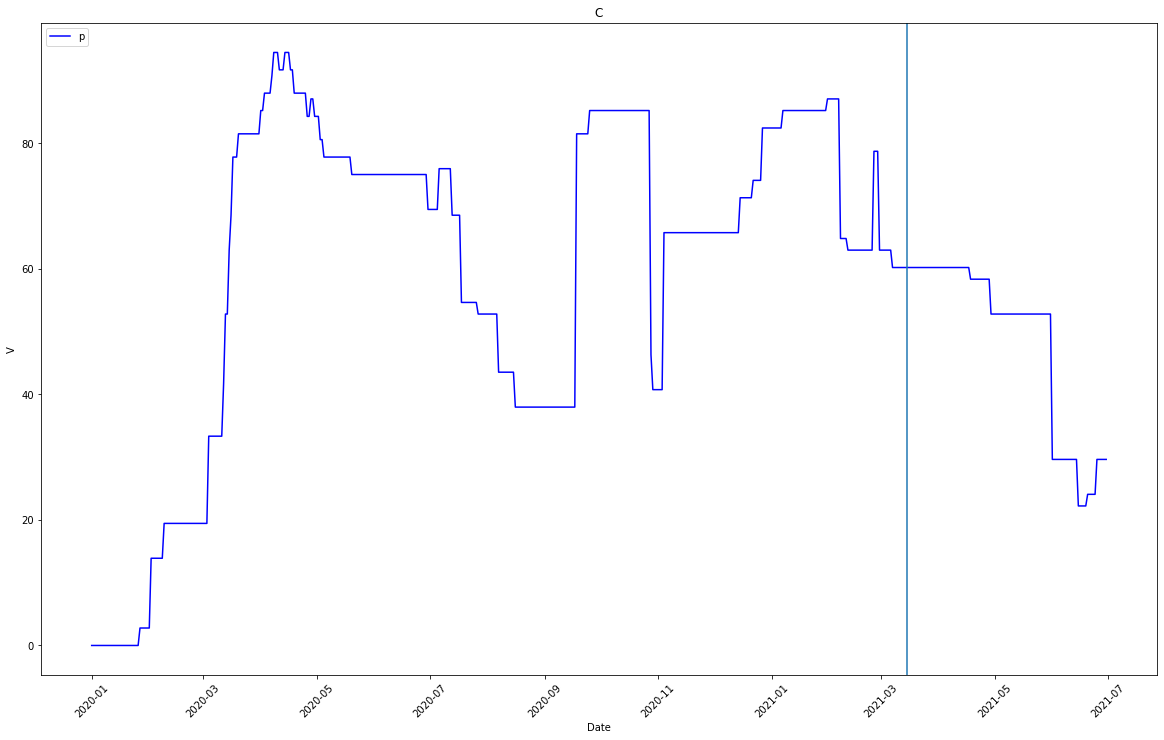

In [45]:
# show MOH daily deaths
fig, ax = plt.subplots(figsize=(20, 12))

#Add x-axis and y-axis
ax.plot(pd.to_datetime(israeli_ox.date_as_date, format='%Y-%m-%d'),
       israeli_ox.StringencyIndex,
       label='p',
       color='blue')



# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="V",
       title="C")

plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.axvline(dt.datetime(2021, 3, 15))
# plt.axvline(dt.datetime(2021, 5, 1))
# plt.axvline(dt.datetime(2021, 7, 1))

## So no, actually stringency was much lower than during the period efficacy was determined. We should have gotten even more deaths! Something else is saving us.

In [46]:
# ## was there lower virus fatality?- we can look at the approximate case fatality ratio over time? let's examine cases and deaths over time.
# seventy_plus_age_split_sum_2021 = seventy_plus_age_split_sum[seventy_plus_age_split_sum.date >'31-12-2020']

# # show MOH daily deaths
# fig, ax = plt.subplots(figsize=(20, 12))
# seventy_plus_age_split_sum_2021['weekly_cfr'] =seventy_plus_age_split_sum_2021.weekly_deceased / seventy_plus_age_split_sum_2021.weekly_cases
# #Add x-axis and y-axis
# ax.(seventy_plus_age_split_sum_2021.date,
#       seventy_plus_age_split_sum_2021.weekly_deceased/ seventy_plus_age_split_sum_2021.weekly_cases,
#        label='case-fatality-ratio',
#        color='red')
# # ax.plot(seventy_plus_age_split_sum.date,
# #        seventy_plus_age_split_sum.weekly_cases,
# #        label='cases',
# #        color='blue')




# # Set title and labels for axes
# ax.set(xlabel="Date",
#        ylabel="V",
#        title="C")

# plt.xticks(rotation=45)
# plt.legend(loc='upper left')

# #plt.axvline(dt.datetime(2021, 3, 15))
# plt.axvline(dt.datetime(2021, 5, 1))
# plt.axvline(dt.datetime(2021, 6, 27))

<a id='section_id_3'></a>
## Let's look at the towns to see if the less vaccinated areas were also seeing drops in deaths different from what we might expect

In [47]:
city_split= pd.read_csv(
    'D:/MAXCORlabwork/covid/most_current_csvs/corona_city_table_ver_00110.csv'
)

In [48]:
city_split.tail(5)

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score
135718,תקוע,3563,2021-07-02,285,286,0,10217,10118,ירוק,2.0
135719,תקוע,3563,2021-07-03,285,286,0,10220,10121,ירוק,2.0
135720,תקוע,3563,2021-07-04,285,286,0,10232,10132,ירוק,2.0
135721,תקוע,3563,2021-07-05,285,286,0,10243,10143,ירוק,2.0
135722,תקוע,3563,2021-07-06,285,287,0,10274,10174,ירוק,2.0


In [49]:
city_split['percent_arab'] = 'to_be_determined'
city_split['percent_haredi'] = 'to_be_determined'
city_split['city_population'] = 'to_be_determined'
city_split

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
0,אבו ג'ווייעד (שבט),967,2020-03-11,0,0,0,0,0,NaN,NaN,to_be_determined,to_be_determined,to_be_determined
1,אבו ג'ווייעד (שבט),967,2020-03-12,0,0,0,0,0,NaN,NaN,to_be_determined,to_be_determined,to_be_determined
2,אבו ג'ווייעד (שבט),967,2020-03-13,0,0,0,0,0,NaN,NaN,to_be_determined,to_be_determined,to_be_determined
3,אבו ג'ווייעד (שבט),967,2020-03-14,0,0,0,0,0,NaN,NaN,to_be_determined,to_be_determined,to_be_determined
4,אבו ג'ווייעד (שבט),967,2020-03-15,0,0,0,0,0,NaN,NaN,to_be_determined,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135718,תקוע,3563,2021-07-02,285,286,0,10217,10118,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
135719,תקוע,3563,2021-07-03,285,286,0,10220,10121,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
135720,תקוע,3563,2021-07-04,285,286,0,10232,10132,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
135721,תקוע,3563,2021-07-05,285,286,0,10243,10143,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined


In [50]:
# city_split_redux = city_split.city_split_redux
# city_split_redux['percent_arab'] = 'to_be_determined'
# #city_split_redux['percent_haredi'groupby('City_Name').sum()
# #] = 'to_be_determined'
# city_split_redux['city_population'] = 'to_be_determined'
# city_split_redux = city_split_redux.drop('final_score', axis =1)
#city_split_redux.to_csv('D:/MAXCORlabwork/covid/most_current_csvs/city_split_redux.csv')


In [51]:
# redux = pd.read_csv('D:/MAXCORlabwork/covid/most_current_csvs/city_split_redux.csv')
# redux.head(5)

In [52]:
city_split.City_Name.unique()

array(["אבו ג'ווייעד (שבט)", 'אבו גוש', 'אבו סנאן', 'אבו קורינאת (שבט)',
       'אבו רובייעה (שבט)', 'אבו רוקייק (שבט)', 'אבו תלול', 'אבטין',
       'אבן יהודה', 'אבני חפץ', 'אום אל-פחם', 'אום בטין', 'אופקים',
       'אור יהודה', 'אור עקיבא', 'אורנית', 'אזור', 'אחוזת ברק',
       'אטרש (שבט)', 'אילת', 'אכסאל', 'אל סייד', 'אלון שבות', 'אליכין',
       'אלעד', 'אלעזר', 'אלפי מנשה', 'אלקנה', 'אעבלין', 'אעצם (שבט)',
       'אפרת', 'אריאל', 'אשדוד', 'אשקלון', 'באקה אל-גרביה', 'באר יעקב',
       'באר שבע', "בועיינה-נוג'ידאת", 'בוקעאתא', 'ביר אל-מכסור',
       "ביר הדאג'", 'בית אל', 'בית אריה', "בית ג'ן", 'בית דגן',
       'בית חשמונאי', 'בית יצחק-שער חפר', 'בית שאן', 'בית שמש',
       'ביתר עילית', 'בני ברק', 'בני עי"ש', 'בנימינה-גבעת עדה', 'בסמ"ה',
       'בסמת טבעון', 'בענה', 'ברכה', 'ברקת', 'בת חפר', 'בת ים',
       'גבע בנימין', 'גבעת אבני', 'גבעת ברנר', 'גבעת זאב', 'גבעת שמואל',
       'גבעתיים', "ג'דיידה-מכר", 'גדרה', "ג'ולס", "ג'לג'וליה", 'גן יבנה',
       'גן נר', 'גני מודיעין', 'גני

In [53]:
city_split.percent_arab[city_split.City_Name == 'באקה אל-גרביה'] = 100

C:\Users\makeda\AppData\Local\Temp/ipykernel_9060/2667299080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_split.percent_arab[city_split.City_Name == 'באקה אל-גרביה'] = 100


In [54]:
baka = city_split[city_split.City_Name == 'באקה אל-גרביה']

In [55]:
baka[baka.Date > '2021-04-30']

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
16838,באקה אל-גרביה,6000,2021-05-01,2769,2741,25,34261,31731,ירוק,1.6,100,to_be_determined,to_be_determined
16839,באקה אל-גרביה,6000,2021-05-02,2769,2741,25,34285,31755,ירוק,1.7,100,to_be_determined,to_be_determined
16840,באקה אל-גרביה,6000,2021-05-03,2769,2742,25,34315,31781,ירוק,1.9,100,to_be_determined,to_be_determined
16841,באקה אל-גרביה,6000,2021-05-04,2769,2742,25,34358,31819,ירוק,2.0,100,to_be_determined,to_be_determined
16842,באקה אל-גרביה,6000,2021-05-05,2769,2742,25,34380,31837,ירוק,2.0,100,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16900,באקה אל-גרביה,6000,2021-07-02,2772,2747,25,37334,34436,ירוק,0.9,100,to_be_determined,to_be_determined
16901,באקה אל-גרביה,6000,2021-07-03,2772,2747,25,37412,34500,ירוק,1.1,100,to_be_determined,to_be_determined
16902,באקה אל-גרביה,6000,2021-07-04,2772,2748,25,37489,34570,ירוק,1.2,100,to_be_determined,to_be_determined
16903,באקה אל-גרביה,6000,2021-07-05,2772,2748,25,37636,34695,ירוק,1.4,100,to_be_determined,to_be_determined


## So using Baka al Gerbiya as an example, we accumulate zero deaths there, in spite of a presumably lower vaccination rate among it's 30,000 residents than the national average.  
## Let's look at some other areas - we will pick ones with large populations we expect to have lower vaccination rates- and see

We would want to look at the following large majority arab locales: ( totalpopulation)
arab locales: ( total population)
    Kafr Qasim : (23,823 )       
    Qalansawe: (23,143)
    Tayibe: (43,957)
    Tira: (26,552)
    Arara: (25,245)
    Baqa al-Gharbiyye: (29,950)
    Umm al-Fahm: (56,109)

In [56]:
kfar_kassem = city_split[city_split.City_Name == 'כפר קאסם']
kfar_kassem[kfar_kassem.Date > '2021-04-30']

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
67070,כפר קאסם,634,2021-05-01,3368,3352,<15,35684,32924,ירוק,1.8,to_be_determined,to_be_determined,to_be_determined
67071,כפר קאסם,634,2021-05-02,3368,3352,<15,35722,32956,ירוק,1.9,to_be_determined,to_be_determined,to_be_determined
67072,כפר קאסם,634,2021-05-03,3368,3353,<15,35742,32973,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
67073,כפר קאסם,634,2021-05-04,3368,3353,<15,35794,33008,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
67074,כפר קאסם,634,2021-05-05,3368,3353,<15,35821,33029,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67132,כפר קאסם,634,2021-07-02,3372,3358,<15,40329,36702,ירוק,1.6,to_be_determined,to_be_determined,to_be_determined
67133,כפר קאסם,634,2021-07-03,3372,3358,<15,40409,36763,ירוק,1.5,to_be_determined,to_be_determined,to_be_determined
67134,כפר קאסם,634,2021-07-04,3372,3358,<15,40526,36859,ירוק,1.4,to_be_determined,to_be_determined,to_be_determined
67135,כפר קאסם,634,2021-07-05,3372,3358,<15,40741,37033,ירוק,1.3,to_be_determined,to_be_determined,to_be_determined


So we see in kfar kassem (notable for being mostly muslim and low SES) deaths stayed recorded at under 15 , unfortunately we did not have an exact number. But maybe we don't get an accurate recording in these areas? Is it possible for people to die at home, COVID-19 unrecorded? Must ask Ronen...in the meantime, let's see קלנסווה

In [57]:
qualansawe = city_split[city_split.City_Name =='קלנסווה']
qualansawe[qualansawe.Date > '2021-04-30']


,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
112472,קלנסווה,638,2021-05-01,2505,2481,16,32267,29831,ירוק,1.3,to_be_determined,to_be_determined,to_be_determined
112473,קלנסווה,638,2021-05-02,2505,2481,16,32298,29858,ירוק,1.2,to_be_determined,to_be_determined,to_be_determined
112474,קלנסווה,638,2021-05-03,2505,2483,16,32402,29949,ירוק,1.3,to_be_determined,to_be_determined,to_be_determined
112475,קלנסווה,638,2021-05-04,2505,2483,16,32443,29989,ירוק,1.4,to_be_determined,to_be_determined,to_be_determined
112476,קלנסווה,638,2021-05-05,2505,2483,16,32542,30075,ירוק,1.6,to_be_determined,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112534,קלנסווה,638,2021-07-02,2506,2492,16,35303,32425,ירוק,1.5,to_be_determined,to_be_determined,to_be_determined
112535,קלנסווה,638,2021-07-03,2506,2492,16,35367,32479,ירוק,1.4,to_be_determined,to_be_determined,to_be_determined
112536,קלנסווה,638,2021-07-04,2506,2493,16,35424,32526,ירוק,1.3,to_be_determined,to_be_determined,to_be_determined
112537,קלנסווה,638,2021-07-05,2506,2493,16,35537,32608,ירוק,1.2,to_be_determined,to_be_determined,to_be_determined


OK, no budge in deaths there either. Now let's check the Arab muslim majority city with the largest numbers

In [58]:
tayibe = city_split[city_split.City_Name == 'טייבה']
tayibe[tayibe.Date > '2021-04-30']

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
49682,טייבה,2730,2021-05-01,4609,4541,45,59382,55677,ירוק,2.7,to_be_determined,to_be_determined,to_be_determined
49683,טייבה,2730,2021-05-02,4609,4546,45,59441,55732,ירוק,2.8,to_be_determined,to_be_determined,to_be_determined
49684,טייבה,2730,2021-05-03,4611,4547,45,59977,56206,ירוק,2.7,to_be_determined,to_be_determined,to_be_determined
49685,טייבה,2730,2021-05-04,4611,4551,45,60082,56294,ירוק,2.5,to_be_determined,to_be_determined,to_be_determined
49686,טייבה,2730,2021-05-05,4611,4554,45,60658,56793,ירוק,2.1,to_be_determined,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49744,טייבה,2730,2021-07-02,4623,4571,45,67114,62306,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
49745,טייבה,2730,2021-07-03,4623,4571,45,67271,62440,ירוק,2.1,to_be_determined,to_be_determined,to_be_determined
49746,טייבה,2730,2021-07-04,4623,4571,45,67432,62578,ירוק,2.2,to_be_determined,to_be_determined,to_be_determined
49747,טייבה,2730,2021-07-05,4624,4571,45,67735,62820,ירוק,2.3,to_be_determined,to_be_determined,to_be_determined


In [59]:
# So we seee zero cumulated deaths here as well even in Tayibe...let's check umm al fahn

In [60]:
um_al_fahn = city_split[city_split.City_Name == 'אום אל-פחם']
um_al_fahn[um_al_fahn.Date > '2021-04-30']

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
5246,אום אל-פחם,2710,2021-05-01,6168,6097,59,58864,55338,ירוק,1.9,to_be_determined,to_be_determined,to_be_determined
5247,אום אל-פחם,2710,2021-05-02,6169,6098,59,58904,55376,ירוק,2.1,to_be_determined,to_be_determined,to_be_determined
5248,אום אל-פחם,2710,2021-05-03,6169,6099,59,58971,55436,ירוק,2.2,to_be_determined,to_be_determined,to_be_determined
5249,אום אל-פחם,2710,2021-05-04,6170,6100,59,59019,55476,ירוק,2.1,to_be_determined,to_be_determined,to_be_determined
5250,אום אל-פחם,2710,2021-05-05,6170,6100,59,59059,55516,ירוק,2.0,to_be_determined,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,אום אל-פחם,2710,2021-07-02,6186,6126,59,63118,59083,ירוק,1.6,to_be_determined,to_be_determined,to_be_determined
5309,אום אל-פחם,2710,2021-07-03,6186,6126,59,63314,59248,ירוק,1.7,to_be_determined,to_be_determined,to_be_determined
5310,אום אל-פחם,2710,2021-07-04,6186,6129,59,63415,59335,ירוק,1.7,to_be_determined,to_be_determined,to_be_determined
5311,אום אל-פחם,2710,2021-07-05,6186,6129,59,63551,59453,ירוק,1.8,to_be_determined,to_be_determined,to_be_determined


## I can't find Araraa ask Ronen for help with spelling maybe?

#arara = city_split[city_split.City_Name == ערערע']
#arara[arara.Date > '2021-04-30']

# Same story in Kfar Kassem, Um al Fahn, Tayibe, Baka, Qualansawe!!! So it seems the surrounding population vaccinating seems to be protecting them from at least deaths. Now what happened in Bnei Barak?

In [61]:
bnei_barak = city_split[city_split.City_Name == 'בני ברק']
bnei_barak[bnei_barak.Date > '2021-04-30']

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,percent_arab,percent_haredi,city_population
24566,בני ברק,6100,2021-05-01,48239,47991,229,375859,346125,ירוק,0.5,to_be_determined,to_be_determined,to_be_determined
24567,בני ברק,6100,2021-05-02,48239,47993,229,376193,346410,ירוק,0.5,to_be_determined,to_be_determined,to_be_determined
24568,בני ברק,6100,2021-05-03,48239,47993,229,376426,346611,ירוק,0.5,to_be_determined,to_be_determined,to_be_determined
24569,בני ברק,6100,2021-05-04,48239,47993,229,376755,346909,ירוק,0.5,to_be_determined,to_be_determined,to_be_determined
24570,בני ברק,6100,2021-05-05,48239,47993,230,376999,347121,ירוק,0.3,to_be_determined,to_be_determined,to_be_determined
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24628,בני ברק,6100,2021-07-02,48248,48015,230,392659,360021,ירוק,0.1,to_be_determined,to_be_determined,to_be_determined
24629,בני ברק,6100,2021-07-03,48248,48016,230,392892,360185,ירוק,0.1,to_be_determined,to_be_determined,to_be_determined
24630,בני ברק,6100,2021-07-04,48248,48016,230,393155,360400,ירוק,0.2,to_be_determined,to_be_determined,to_be_determined
24631,בני ברק,6100,2021-07-05,48248,48017,230,393601,360758,ירוק,0.2,to_be_determined,to_be_determined,to_be_determined


## In Bnei Barak they added on single death in May and June! Looks like the less vaccinated areas are benefiting from us!

## We could sum these areas populations, get person years, then get some kind of expected deaths...
But this is too much work for very little reward when the number is about ZERO barring the onme Bnei barak...

## Let's think about the most important questions:
1. Is the same true for the general population. Did we get lower deaths than expected in young people as well?
2. How much is reduced transmission, versus reduced deadlyness once you catch it?



## Proposed calculations to adress these and other questions:

1. 
A. Try, given whatever data possible, to calculate the expected and real cases and deaths for whole population
B. Think about taking an age slice in the middle of 16 to 45 i.e. 26 to 36 to examine

    

2. 
A. Look at percentages of people who catch the virus in an age group who die over time (some more MOH data may be neccesary). 
   
B. Look at R and see if it can be made to account for changes in cases in deaths: SPOILER alert- it can't, really by my preliminary calculations. We were probably looking at an increase in vaccinated people catching the disease, and experiencing very few symptoms. 

<a id='section_id_4'></a>
## What is really happening when we look at R?
We will start with the Israeli MOH data on R

In [62]:
## Here is R as calculated by the MOH , which makes me think we are not seeing a phenomenon decreased transmission
R = pd.read_csv(
    'D:/MAXCORlabwork/covid/vax_saves_lives_paper/R_for_israel_from_MOH.csv'
)
R.head(5)


,?????,???? ?????
0,01-03-2020,2.64
1,02-03-2020,2.25
2,03-03-2020,2.39
3,04-03-2020,2.44
4,05-03-2020,2.36


In [63]:
R = R.rename(columns = {'?????': 'date_as_date', '???? ?????': 'r'})
R.tail(15)

,date_as_date,r
468,12-06-2021,2.08
469,13-06-2021,2.27
470,14-06-2021,2.45
471,15-06-2021,2.47
472,16-06-2021,2.29
473,17-06-2021,2.17
474,18-06-2021,1.92
475,19-06-2021,1.84
476,20-06-2021,1.75
477,21-06-2021,1.54


In [64]:
R['date_as_date']=pd.to_datetime(R['date_as_date'], format ='%d-%m-%Y')

In [65]:
# red_time = R[R.r >=1]
# red_time['colors'] = 'red'
# green_time = R[R.r <1] 
# green_time['colors'] = 'green'
# nr =red_time.merge (green_time, on = 'date_as_date')
# nr
near1 =[0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06, 1.07,1.08,1.09,]
R['colors'] = np.where(R['r']<1.0, 'green','red')
R['colors'] = np.where(R['r'].isin(near1), 'yellow', R['colors'])
R.tail(25)

,date_as_date,r,colors
458,2021-06-02,0.89,green
459,2021-06-03,0.89,green
460,2021-06-04,1.12,red
461,2021-06-05,1.07,yellow
462,2021-06-06,1.13,red
463,2021-06-07,1.18,red
464,2021-06-08,1.28,red
465,2021-06-09,1.54,red
466,2021-06-10,1.77,red
467,2021-06-11,2.02,red


In [66]:
# help(ax.scatter)
R.colors

0      red
1      red
2      red
3      red
4      red
      ... 
478    red
479    red
480    red
481    red
482    red
Name: colors, Length: 483, dtype: object

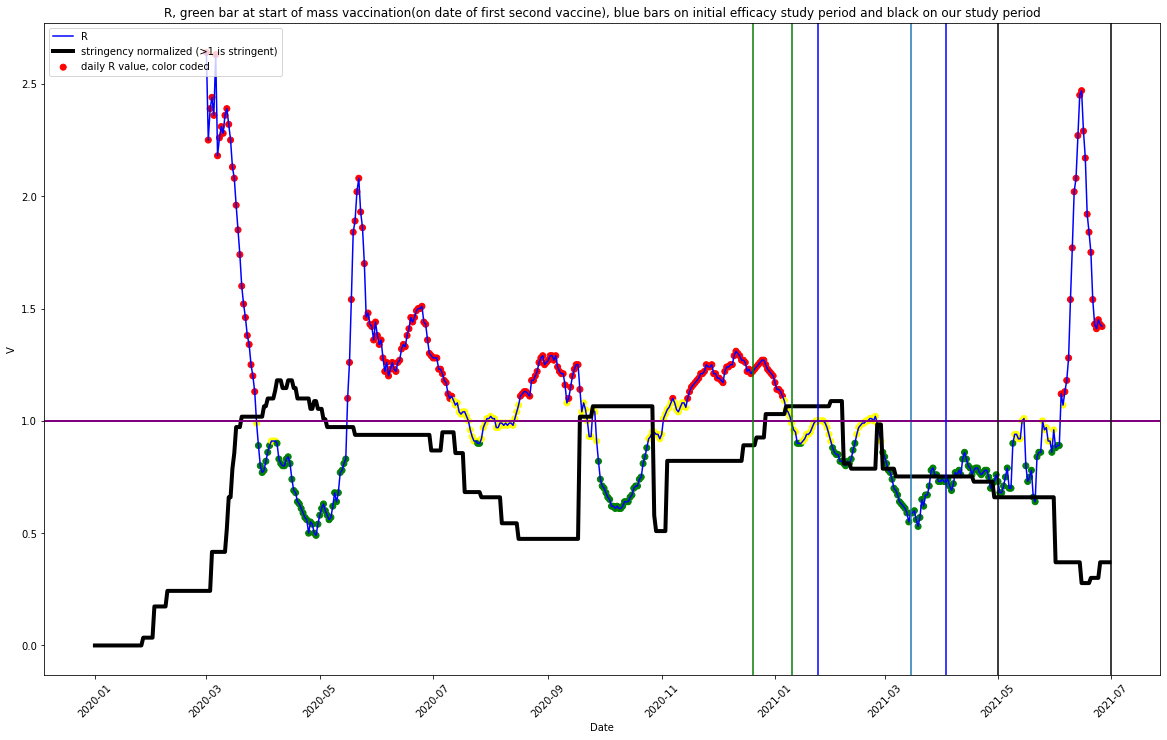

In [67]:
# from matplotlib.collections import LineCollection
# rc('axes', linewidth=4)
# # show MOH daily deaths
fig, ax = plt.subplots(figsize=(20, 12))

#Add x-axis and y-axis
ax.scatter(
    x=R.date_as_date,
    y=R.r,
    label='daily R value, color coded',
    #color=R['colors'],
    c=R.colors,    
    cmap='gray',
)
ax.plot(
    R.date_as_date,
    R.r,
    label='R',
    color='blue',
)
       #c= R.colors,    
       #cmap = 'gray')

ax.plot(
    pd.to_datetime(israeli_ox.date_as_date, format='%Y-%m-%d'),
    israeli_ox.StringencyIndex / 80,
    label='stringency normalized (>1 is stringent)',
    color='black',
    linewidth=4,
)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="V",
       title="C")

plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title('R, green bar at start of mass vaccination(on date of first second vaccine), blue bars on initial efficacy study period and black on our study period')
plt.axvline(dt.datetime(2021, 3, 15))
plt.axhline(1., color = 'purple', linewidth=2);
plt.axvline(dt.datetime(2020, 12, 20), color = 'green')
plt.axvline(dt.datetime(2021, 1, 10), color = 'green')
plt.axvline(dt.datetime(2021, 1, 24), color = 'blue')
plt.axvline(dt.datetime(2021, 4, 3), color = 'blue')
plt.axvline(dt.datetime(2021, 5, 1), color = 'black')
plt.axvline(dt.datetime(2021, 7, 1), color = 'black');

In [68]:
# grouped = R.groupby('colors')
# fig, ax = plt.subplots(1)

# for key, group in grouped:
#    group.plot(ax=ax, x="date_as_date", y="r", label=key, color=key)

In [73]:
# so we need to do some kind of correlation number to show that
# we could use weekly time point differences for psuedo-derivative..
# but let's try a time series Pearson's or Spearman's correlation
israeli_ox.date_as_date = pd.to_datetime(israeli_ox.date_as_date, format='%Y-%m-%d')
for_corr= israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr.drop(['date_as_date','colors'], axis = 1)

,Unnamed: 0,StringencyIndex,r
date_as_date,,,
2020-03-01,89079,19.44,2.64
2020-03-02,89080,19.44,2.25
2020-03-03,89081,19.44,2.39
2020-03-04,89082,33.33,2.44
2020-03-05,89083,33.33,2.36
...,...,...,...
2021-06-22,89557,24.07,1.43
2021-06-23,89558,24.07,1.41
2021-06-24,89559,24.07,1.45


In [74]:
total_pearson_r = for_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series: {total_pearson_r}")
total_spearman_r = for_corr.corr(method ='spearman').iloc[0,1]
print(f"Pandas computed Spearman r for entire time series: {total_spearman_r}")

Pandas computed Pearson r for entire time series: -0.3392680590185147
Pandas computed Spearman r for entire time series: -0.37670284102369755


In [75]:
total_pearson_r = for_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series: {total_pearson_r}")
total_spearman_r = for_corr.corr(method ='spearman').iloc[0,1]
print(f"Pandas computed Spearman r for entire time series: {total_spearman_r}")

Pandas computed Pearson r for entire time series: -0.3392680590185147
Pandas computed Spearman r for entire time series: -0.37670284102369755


In [76]:
# So basically, overall there was not such a big correlation- which makes sense becuase it the correlation flipped when we vaxed
#let' try before vaccines
corr_before_vaccines = for_corr[for_corr.date_as_date < '2021-01-10' ]
prevax_pearson_r = corr_before_vaccines.corr(method ='pearson').iloc[0,1]

print(f"Pandas computed Pearson r for time series before vaccination: {prevax_pearson_r}")

Pandas computed Pearson r for time series before vaccination: -0.06065080953560726


In [77]:
# So we saw a moderate inverse correlation before vaccines. The higher the stringency, the lower the R
# we would assume we could get higher with a time lag cross correlation

# but let's check after vaccination
corr_after_vaccines = for_corr[for_corr.date_as_date > '2021-01-10' ]
postvax_pearson_r = corr_after_vaccines.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series after vaccination: {postvax_pearson_r}")

Pandas computed Pearson r for time series after vaccination: -0.9072286226406966


##  Oh, yeah the delta variant came along, and shot R up...well Ronen will have to decide where to cut. Let's just look until June:

In [78]:
corr_interem_vaccines = corr_after_vaccines[corr_after_vaccines.date_as_date < '2021-06-01' ]
interem_pearson_r = corr_interem_vaccines.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series after vaccination but before June: {interem_pearson_r}")

Pandas computed Pearson r for time series after vaccination but before June: -0.8624322496972849


In [79]:
# So the obvious uestion is what happens if we time shift
time_shift_minus3_corr = for_corr
#time_shift_corr = time_shift_corr.rename(columns = {'date_1s_date':'old_date'})
time_shift_minus3_corr.r = time_shift_minus3_corr.r.shift(-3)
time_shift_minus3_corr

,Unnamed: 0,date_as_date,StringencyIndex,r,colors
date_as_date,,,,,
2020-03-01,89079,2020-03-01,19.44,2.44,red
2020-03-02,89080,2020-03-02,19.44,2.36,red
2020-03-03,89081,2020-03-03,19.44,2.63,red
2020-03-04,89082,2020-03-04,33.33,2.18,red
2020-03-05,89083,2020-03-05,33.33,2.26,red
...,...,...,...,...,...
2021-06-22,89557,2021-06-22,24.07,1.43,red
2021-06-23,89558,2021-06-23,24.07,1.42,red
2021-06-24,89559,2021-06-24,24.07,NaN,red


In [80]:
for_corr= israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr.drop(['date_as_date','colors'], axis = 1)
# So the obvious uestion is what happens if we time shift
time_shift_minus4_corr = for_corr
#time_shift_corr = time_shift_corr.rename(columns = {'date_1s_date':'old_date'})
time_shift_minus4_corr.r = time_shift_minus4_corr.r.shift(-4)
#time_shift_minus4_corr
for_corr.to_csv('for_corr.csv')

In [81]:
for_corr= israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr.drop(['date_as_date','colors'], axis = 1)
# So the obvious uestion is what happens if we time shift
time_shift_minus5_corr = for_corr
#time_shift_corr = time_shift_corr.rename(columns = {'date_1s_date':'old_date'})
time_shift_minus5_corr.r = time_shift_minus5_corr.r.shift(-5)
for_corr= israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr.drop(['date_as_date','colors'], axis = 1)
time_shift_minus6_corr = for_corr
#time_shift_corr = time_shift_corr.rename(columns = {'date_1s_date':'old_date'})
time_shift_minus6_corr.r = time_shift_minus6_corr.r.shift(-6)
for_corr= israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr.drop(['date_as_date','colors'], axis = 1)
time_shift_minus7_corr = for_corr
#time_shift_corr = time_shift_corr.rename(columns = {'date_1s_date':'old_date'})
time_shift_minus7_corr.r = time_shift_minus7_corr.r.shift(-7)
time_shift_minus6_corr.tail(10)


,Unnamed: 0,date_as_date,StringencyIndex,r,colors
date_as_date,,,,,
2021-06-17,89552,2021-06-17,22.22,1.41,red
2021-06-18,89553,2021-06-18,22.22,1.45,red
2021-06-19,89554,2021-06-19,22.22,1.43,red
2021-06-20,89555,2021-06-20,24.07,1.42,red
2021-06-21,89556,2021-06-21,24.07,NaN,red
2021-06-22,89557,2021-06-22,24.07,NaN,red
2021-06-23,89558,2021-06-23,24.07,NaN,red
2021-06-24,89559,2021-06-24,24.07,NaN,red
2021-06-25,89560,2021-06-25,29.63,NaN,red


In [82]:
time_shift_total_pearson_m3_r = time_shift_minus3_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series with shift 3: {time_shift_total_pearson_m3_r }")
time_shift_total_pearson_m4_r = time_shift_minus4_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series with sift 4: {time_shift_total_pearson_m4_r }")

Pandas computed Pearson r for entire time series with shift 3: -0.3392680590185147
Pandas computed Pearson r for entire time series with sift 4: -0.3392680590185147


In [83]:
time_shift_total_pearson_m5_r = time_shift_minus5_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series with shift 5: {time_shift_total_pearson_m5_r }")
time_shift_total_pearson_m6_r = time_shift_minus6_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series with shift 6: {time_shift_total_pearson_m6_r }")
time_shift_total_pearson_m7_r = time_shift_minus7_corr.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for entire time series with shift 7: {time_shift_total_pearson_m7_r }")

Pandas computed Pearson r for entire time series with shift 5: -0.3392680590185147
Pandas computed Pearson r for entire time series with shift 6: -0.3392680590185147
Pandas computed Pearson r for entire time series with shift 7: -0.3392680590185147


In [84]:
# still overall we don't see the pattern thanks to vaccination and delta variants, but let's look pre-vax
ts_corr_before_vaccines3 = time_shift_minus3_corr[time_shift_minus3_corr.date_as_date < '2021-01-10' ]
ts_prevax_pearson_r3 = ts_corr_before_vaccines3.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series with 3 day shift before vaccination: {ts_prevax_pearson_r3}")
ts_corr_before_vaccines4 = time_shift_minus4_corr[time_shift_minus4_corr.date_as_date < '2021-01-10' ]
ts_prevax_pearson_r4 = ts_corr_before_vaccines4.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series with 4 day shift before vaccination: {ts_prevax_pearson_r4}")
ts_corr_before_vaccines5 = time_shift_minus5_corr[time_shift_minus5_corr.date_as_date < '2021-01-10' ]
ts_prevax_pearson_r5 = ts_corr_before_vaccines5.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series with 5 day shift before vaccination: {ts_prevax_pearson_r5}")

ts_corr_before_vaccines6 = time_shift_minus6_corr[time_shift_minus6_corr.date_as_date < '2021-01-10' ]
ts_prevax_pearson_r6 = ts_corr_before_vaccines6.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series with 6 day shift before vaccination: {ts_prevax_pearson_r6}")
ts_corr_before_vaccines7 = time_shift_minus7_corr[time_shift_minus7_corr.date_as_date < '2021-01-10' ]
ts_prevax_pearson_r7 = ts_corr_before_vaccines7.corr(method ='pearson').iloc[0,1]
print(f"Pandas computed Pearson r for time series with 7 day shift before vaccination: {ts_prevax_pearson_r7}")

Pandas computed Pearson r for time series with 3 day shift before vaccination: -0.06065080953560726
Pandas computed Pearson r for time series with 4 day shift before vaccination: -0.06065080953560726
Pandas computed Pearson r for time series with 5 day shift before vaccination: -0.06065080953560726
Pandas computed Pearson r for time series with 6 day shift before vaccination: -0.06065080953560726
Pandas computed Pearson r for time series with 7 day shift before vaccination: -0.06065080953560726


In [85]:
ts_corr_before_vaccines

NameError: name 'ts_corr_before_vaccines' is not defined

In [86]:

for_corr = israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')

for i in range(-14, 7):
#     for_corr.drop(['date_as_date','colors'], axis = 1)
# So the obvious uestion is what happens if we time shift
    #time_shift_minus4_corr = for_corr
    for_corr_copy = for_corr.copy()
    for_corr_copy['r'] = for_corr['r'].shift(i)
    end = pd.to_datetime('2021-01-10', format='%Y-%m-%d')
    ts_corr_before_vaccines = for_corr_copy[for_corr_copy['date_as_date'] < end]
    ts_prevax_pearson_r = ts_corr_before_vaccines['r'].corr(
        method='pearson',
        other=ts_corr_before_vaccines['StringencyIndex'],
    )
#     ts_prevax_spearman_r = ts_corr_before_vaccines['r'].corr(
#         method ='spearman',
#         other=ts_corr_before_vaccines['StringencyIndex'],
#     )
    print('''
        Pandas computed Pearson r for time series with,
        i = {} day shift before vaccination:
        ts_prevax_pearson_r = {}
    '''.format(i, ts_prevax_pearson_r)
    )
#     print('''
#         Pandas computed Spearman r for time series with,
#         i = {} day shift before vaccination:
#         ts_prevax_spearman_r = {}
#     '''.format(i, ts_prevax_spearman_r)
#     )
    #print


        Pandas computed Pearson r for time series with,
        i = -14 day shift before vaccination:
        ts_prevax_pearson_r = -0.435089352836222
    

        Pandas computed Pearson r for time series with,
        i = -13 day shift before vaccination:
        ts_prevax_pearson_r = -0.4621374395285325
    

        Pandas computed Pearson r for time series with,
        i = -12 day shift before vaccination:
        ts_prevax_pearson_r = -0.48421531076026497
    

        Pandas computed Pearson r for time series with,
        i = -11 day shift before vaccination:
        ts_prevax_pearson_r = -0.5030439690365807
    

        Pandas computed Pearson r for time series with,
        i = -10 day shift before vaccination:
        ts_prevax_pearson_r = -0.516054975341378
    

        Pandas computed Pearson r for time series with,
        i = -9 day shift before vaccination:
        ts_prevax_pearson_r = -0.5224418083554009
    

        Pandas computed Pearson r for time series wit

In [87]:
# let's check spearman
for_corr = israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')

for i in range(-14, 7):
#     for_corr.drop(['date_as_date','colors'], axis = 1)
# So the obvious uestion is what happens if we time shift
    #time_shift_minus4_corr = for_corr
    for_corr_copy = for_corr.copy()
    for_corr_copy['r'] = for_corr['r'].shift(i)
    end = pd.to_datetime('2021-01-10', format='%Y-%m-%d')
    ts_corr_before_vaccines = for_corr_copy[for_corr_copy['date_as_date'] < end]
#     ts_prevax_pearson_r = ts_corr_before_vaccines['r'].corr(
#         method='pearson',
#         other=ts_corr_before_vaccines['StringencyIndex'],
#     )
    ts_prevax_spearman_r = ts_corr_before_vaccines.corr(
        method ='spearman',
        #other=ts_corr_before_vaccines['StringencyIndex'],
    )
#     print('''
#         Pandas computed Pearson r for time series with,
#         i = {} day shift before vaccination:
#         ts_prevax_pearson_r = {}
#     '''.format(i, ts_prevax_pearson_r)
#     )
    print('''
        Pandas computed Spearman r for time series with,
        i = {} day shift before vaccination:
        ts_prevax_spearman_r = {}
    '''.format(i, ts_prevax_spearman_r)
    )
    #print


        Pandas computed Spearman r for time series with,
        i = -14 day shift before vaccination:
        ts_prevax_spearman_r =                  Unnamed: 0  StringencyIndex         r
Unnamed: 0         1.000000        -0.143733  0.024216
StringencyIndex   -0.143733         1.000000 -0.532912
r                  0.024216        -0.532912  1.000000
    

        Pandas computed Spearman r for time series with,
        i = -13 day shift before vaccination:
        ts_prevax_spearman_r =                  Unnamed: 0  StringencyIndex         r
Unnamed: 0         1.000000        -0.143733  0.016155
StringencyIndex   -0.143733         1.000000 -0.552995
r                  0.016155        -0.552995  1.000000
    

        Pandas computed Spearman r for time series with,
        i = -12 day shift before vaccination:
        ts_prevax_spearman_r =                  Unnamed: 0  StringencyIndex         r
Unnamed: 0         1.000000        -0.143733  0.008453
StringencyIndex   -0.143733        

In [88]:
total_spearman_r_prevax = ts_corr_before_vaccines.corr(method ='spearman').iloc[0,1]
print(f"Pandas computed Spearman r for  time series before vax: {total_spearman_r_prevax}")

Pandas computed Spearman r for  time series before vax: -0.1437329640231808


In [89]:
for_corr = israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr

,Unnamed: 0,date_as_date,StringencyIndex,r,colors
date_as_date,,,,,
2020-03-01,89079,2020-03-01,19.44,2.64,red
2020-03-02,89080,2020-03-02,19.44,2.25,red
2020-03-03,89081,2020-03-03,19.44,2.39,red
2020-03-04,89082,2020-03-04,33.33,2.44,red
2020-03-05,89083,2020-03-05,33.33,2.36,red
...,...,...,...,...,...
2021-06-22,89557,2021-06-22,24.07,1.43,red
2021-06-23,89558,2021-06-23,24.07,1.41,red
2021-06-24,89559,2021-06-24,24.07,1.45,red


In [90]:
moh = pd.read_csv('D:/MAXCORlabwork/covid/most_current_csvs/covid19-data-israel-30062021.csv')
moh = moh.rename(columns={'תאריך':'date','מספר נפטרים מצטבר':'cumu_deaths'})
moh.cumu_deaths = moh.cumu_deaths.str.replace(',', '')
moh.cumu_deaths = pd.to_numeric(moh.cumu_deaths)
moh['daily_deaths'] = moh.cumu_deaths - moh.cumu_deaths.shift()
moh['date_as_date'] = pd.to_datetime(moh.date)
moh.index = pd.to_datetime(moh['date_as_date'], format='%Y-%m-%d')#print(type(moh.date_as_date[3]))
moh = moh.rename(columns = {'date_as_date':'col_date'})
for_corr = for_corr.rename(columns = {'date_as_date':'col_date'})
for_corr_deaths = for_corr.merge(moh, on='date_as_date' )
for_corr_deaths= for_corr_deaths.rename(columns = {'מספר חולים מונשמים':'intubated'})#['date_as_date'] = for_corr_deaths['col_date']

In [91]:
for i in range(-7, 17):
#     for_corr.drop(['date_as_date','colors'], axis = 1)
# So the obvious uestion is what happens if we time shift
    #time_shift_minus4_corr = for_corr
    for_corr_deaths_copy = for_corr_deaths.copy()
    for_corr_deaths_copy['intubated'] = for_corr_deaths['intubated'].shift(i)
    end = pd.to_datetime('2021-01-10', format='%Y-%m-%d')
    ts_corr_deaths_before_vaccines = for_corr_deaths_copy[for_corr_deaths_copy['col_date_x'] < end]
    ts_prevax_deaths_pearson_r = ts_corr_deaths_before_vaccines['intubated'].corr(
        method='pearson',
        other=ts_corr_deaths_before_vaccines['daily_deaths'],
    )
    print('''
        Pandas computed Pearson r for time series r versus deaths with,
        i = {} day shift (before vaccination):
        ts_prevax_pearson_r = {}
    '''.format(i, ts_prevax_deaths_pearson_r)
    )
    #print


        Pandas computed Pearson r for time series r versus deaths with,
        i = -7 day shift (before vaccination):
        ts_prevax_pearson_r = 0.2830513857809526
    

        Pandas computed Pearson r for time series r versus deaths with,
        i = -6 day shift (before vaccination):
        ts_prevax_pearson_r = 0.31817489368074936
    

        Pandas computed Pearson r for time series r versus deaths with,
        i = -5 day shift (before vaccination):
        ts_prevax_pearson_r = 0.3471296541695833
    

        Pandas computed Pearson r for time series r versus deaths with,
        i = -4 day shift (before vaccination):
        ts_prevax_pearson_r = 0.37309611364770096
    

        Pandas computed Pearson r for time series r versus deaths with,
        i = -3 day shift (before vaccination):
        ts_prevax_pearson_r = 0.43251398101479116
    

        Pandas computed Pearson r for time series r versus deaths with,
        i = -2 day shift (before vaccination):
       

In [92]:
for_corr = israeli_ox.merge(R, on='date_as_date')
for_corr.index = pd.to_datetime(for_corr['date_as_date'], format='%Y-%m-%d')
for_corr = for_corr.rename(columns = {'date_as_date':'col_date'})
for_corr_deaths = for_corr.merge(moh, on='date_as_date' )
for_corr_deaths= for_corr_deaths.rename(columns = {'מספר חולים מונשמים':'intubated'})#['date_as_date'] = for_corr_deaths['col_date']

for_corr_deaths_copy = for_corr_deaths_copy.rename(columns={'מספר חולים מצטבר':'total_patients'}) 
for_corr_deaths_copy.total_patients = for_corr_deaths_copy.total_patients.str.replace(',', '')
for_corr_deaths_copy.total_patients = pd.to_numeric(for_corr_deaths_copy.total_patients)
for_corr_deaths_copy['new_patients'] = for_corr_deaths_copy.total_patients - for_corr_deaths_copy.total_patients.shift()

In [93]:
for_corr_deaths_copy

,Unnamed: 0,col_date_x,StringencyIndex,r,colors,date,מספר בדיקות מצטבר,מספר חולים מאושפזים,intubated,total_patients,מספר חולים קשה,cumu_deaths,daily_deaths,col_date_y,new_patients
date_as_date,,,,,,,,,,,,,,,
2020-03-02,89080,2020-03-02,19.44,2.25,red,03/02/2020 00:00:00,161,0,NaN,7,0,0,0.0,2020-03-02,NaN
2020-03-03,89081,2020-03-03,19.44,2.39,red,03/03/2020 00:00:00,"1,989",10,NaN,22,0,0,0.0,2020-03-03,15.0
2020-03-04,89082,2020-03-04,33.33,2.44,red,03/04/2020 00:00:00,"106,950",816,NaN,7756,131,43,5.0,2020-03-04,7734.0
2020-03-05,89083,2020-03-05,33.33,2.36,red,03/05/2020 00:00:00,"405,372",327,NaN,16130,101,236,3.0,2020-03-05,8374.0
2020-03-06,89084,2020-03-06,33.33,2.63,red,03/06/2020 00:00:00,"607,822",122,NaN,17435,28,295,1.0,2020-03-06,1305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-22,89557,2021-06-22,24.07,1.43,red,22/06/2021 00:00:00,"17,476,675",56,32.0,840119,26,6428,0.0,2021-06-22,111.0
2021-06-23,89558,2021-06-23,24.07,1.41,red,23/06/2021 00:00:00,"17,520,048",58,218.0,840259,25,6429,1.0,2021-06-23,140.0
2021-06-24,89559,2021-06-24,24.07,1.45,red,24/06/2021 00:00:00,"17,561,483",55,319.0,840488,23,6429,0.0,2021-06-24,229.0


In [94]:
for_corr_deaths_copy['מספר חולים קשה'] = for_corr_deaths_copy['מספר חולים קשה'].str.replace(',', '')
for_corr_deaths_copy['מספר חולים קשה'] = pd.to_numeric(for_corr_deaths_copy['מספר חולים קשה'])
for i in range(-7, 14):
#     for_corr.drop(['date_as_date','colors'], axis = 1)
# So the obvious uestion is what happens if we time shift
    #time_shift_minus4_corr = for_corr
    #for_corr_deaths_copy = for_corr_deaths.copy()
    for_corr_deaths_copy['מספר חולים קשה'] = for_corr_deaths_copy['מספר חולים קשה'].shift(i)
    end = pd.to_datetime('2021-06-10', format='%Y-%m-%d')
    ts_corr_deaths = for_corr_deaths_copy[for_corr_deaths_copy['col_date_x'] < end]
    ts_deaths_pearson_r = ts_corr_deaths['מספר חולים קשה'].corr(
        method='pearson',
        other=ts_corr_deaths_before_vaccines['daily_deaths'],
    )
    print('''
        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = {} day shift :
        ts_prevax_pearson_r = {}
    '''.format(i, ts_deaths_pearson_r)
    )
    #print


        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = -7 day shift :
        ts_prevax_pearson_r = 0.25403587989071796
    

        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = -6 day shift :
        ts_prevax_pearson_r = 0.28433743793895877
    

        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = -5 day shift :
        ts_prevax_pearson_r = 0.27240884062445886
    

        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = -4 day shift :
        ts_prevax_pearson_r = 0.24729093766973434
    

        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = -3 day shift :
        ts_prevax_pearson_r = 0.28512711974492416
    

        Pandas computed Pearson r for time series severely ill versus deaths with,
        i = -2 day shift :
        ts_prevax_pearson_r = 0.2955672338003131
    

    

In [95]:
for_deriv = pd.read_csv('for_corr.csv')
# for_deriv['si_diff'] = for_deriv.StringencyIndex/for_deriv.StringencyIndex.shift()
# for_deriv['r_diff'] = for_deriv.r/for_deriv.r.shift()


In [96]:
#fig, ax = plt.subplots(figsize=(20, 12))

#Add x-axis and y-axis
# ax.plot(for_deriv.date_as_date,
#        for_deriv['re_log'],
#        label='daily R diff log, color coded',
#        #color=R['colors'],
#        color='green',)
# ax.plot(for_deriv.date_as_date,
#        for_deriv.r,
#        label='r',
#        color='blue',)
       #c= R.colors,    
       #cmap = 'gray')


## So from January to June, government stringency and R were moderatly positively correlated - because reverse causality. Or beccause the the government reacted when R went up, but then also influenced R. After vaccinations,something else caused R to go down, and they let up on the stringency with little effect. The something else was probably vaccines, plus or minus better contact tracing and isolation? And by the way, what about R and deaths?

In [103]:
death_data = pd.read_csv('D:/MAXCORlabwork/covid/most_current_csvs/maxcor_covid_w_oxf_stringency_data_simple.csv')
#death_data = death_data.rename(columns={'date':'date_as_date'})
death_data['date_as_date'] = pd.to_datetime(death_data['date'],format='%d/%m/%Y %H:%M:%S')

In [104]:
merge_deaths = for_corr.drop('colors', axis = 1)
merge_deaths#= merge_deaths.rename(columns =)

,Unnamed: 0,col_date,StringencyIndex,r
date_as_date,,,,
2020-03-01,89079,2020-03-01,19.44,2.64
2020-03-02,89080,2020-03-02,19.44,2.25
2020-03-03,89081,2020-03-03,19.44,2.39
2020-03-04,89082,2020-03-04,33.33,2.44
2020-03-05,89083,2020-03-05,33.33,2.36
...,...,...,...,...
2021-06-22,89557,2021-06-22,24.07,1.43
2021-06-23,89558,2021-06-23,24.07,1.41
2021-06-24,89559,2021-06-24,24.07,1.45


In [105]:
death_data

,Unnamed: 0,date,number_tests,number_patients_admitted,total_intubated,number_sick,number_kashim,deaths,total_deaths_n,daily_deaths,date_as_date,result_date,test_positive,total_tested,VaccinationDate,first_dose,second_dose,StringencyIndex
0,0,26/01/2020 00:00:00,136,0,0,7,0,0,0,NaN,2020-01-26,NaN,NaN,NaN,2020-01-26 00:00:00,0.0,0.0,0.00
1,1,27/01/2020 00:00:00,137,0,0,7,0,0,0,0.0,2020-01-27,NaN,NaN,NaN,2020-01-27 00:00:00,0.0,0.0,2.78
2,2,28/01/2020 00:00:00,137,0,0,7,0,0,0,0.0,2020-01-28,NaN,NaN,NaN,2020-01-28 00:00:00,0.0,0.0,2.78
3,3,29/01/2020 00:00:00,143,0,0,7,0,0,0,0.0,2020-01-29,NaN,NaN,NaN,2020-01-29 00:00:00,0.0,0.0,2.78
4,4,30/01/2020 00:00:00,147,0,0,7,0,0,0,0.0,2020-01-30,NaN,NaN,NaN,2020-01-30 00:00:00,0.0,0.0,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,517,26/06/2021 00:00:00,"17,652,858",50,16,"840,834",25,"6,429",6429,0.0,2021-06-26,2021-06-26,130.0,33054.0,2021-06-26,2160.0,95.0,29.63
518,518,27/06/2021 00:00:00,"17,693,241",63,16,"840,979",24,"6,429",6429,0.0,2021-06-27,2021-06-27,149.0,40379.0,2021-06-27,13498.0,3278.0,29.63
519,519,28/06/2021 00:00:00,"17,761,419",61,16,"841,267",22,"6,429",6429,0.0,2021-06-28,2021-06-28,303.0,68178.0,2021-06-28,14308.0,3464.0,29.63
520,520,29/06/2021 00:00:00,"17,829,423",67,16,"841,560",22,"6,429",6429,0.0,2021-06-29,2021-06-29,315.0,68002.0,2021-06-29,16448.0,3494.0,29.63


In [106]:
# let's show our lowest ever R since last year:
R.r.min()

0.49

In [107]:
recentR= R[R.date_as_date > '01-01-2021']

In [108]:
# how about the minimum R tis year?
recentR.r.min()

0.53

In [109]:
# we could look at the correlation between stringency and R before and after vaccination?

## We can try to calcuate, with the idea that this would decrease the spread , and check against how it actually spread for better numbers